**I chose to scrape the wikipedia page using beautifulsoup. I used the library 'requests' to pull data from the url, found the table as a class 'wikitable', then iterated over table data fields to create an array out of the scraped data.**

In [144]:
import requests 
url= requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

from bs4 import BeautifulSoup
soup=BeautifulSoup(url,'lxml')
table=soup.find('table',{'class':'wikitable'})

**Derived a table from the scraped web data, then transformed that table into a pandas dataframe.**

In [145]:
import pandas as pd

#generate an empty list from which to append data from web scraping
columns=[]

#iteratively get data from table rows to emplace into the columns list.
for row in table.findAll('tr')[1:]:
    col=row.findAll('td')
    columns.append(col)

#generating dataframe from the list
df=pd.DataFrame(columns,columns=['Postal Code','Borough','Neighborhood'])
df=df.applymap(str)

df.head()

,Postal Code,Borough,Neighborhood
0,<td>M1A\n</td>,<td>Not assigned\n</td>,<td>Not assigned\n</td>
1,<td>M2A\n</td>,<td>Not assigned\n</td>,<td>Not assigned\n</td>
2,<td>M3A\n</td>,<td>North York\n</td>,<td>Parkwoods\n</td>
3,<td>M4A\n</td>,<td>North York\n</td>,<td>Victoria Village\n</td>
4,<td>M5A\n</td>,<td>Downtown Toronto\n</td>,"<td>Regent Park, Harbourfront\n</td>"


**The data needed a bit of cleaning. I wanted to remove 'Not assigned' values from df['Borough'], and remove unwanted characters that were pulled from the html parser.**

In [146]:
#removing unwanted characters resulting from parsing the html script.

dfCol=['Postal Code','Borough','Neighborhood']

for col in dfCol:
    df[col]=df[col].str.replace('<td>','')
    df[col]=df[col].str.replace('</td>','')
    df[col]=df[col].str.replace('\n','')

#removing 'Not assigned' values from df['Borough']
df.drop(df.loc[df['Borough']=='Not assigned'].index, inplace=True)

#I originally wasn't sure if the 'Neighborhood' column had any 'Not assigned' values after dropping the 'Not assigned' values from df['Borough']. I used a few methods, df['Neighborhoods'].loc, df['Neighborhoods'].value_count to confirm there were none. 
#df.drop(df.loc[df['Neighborhood']=='Not assigned'].index, inplace=True)

df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [147]:
print(df.shape)

(103, 3)


**Generate a dataframe from the read csv containing coordinates corresponding to Postal Code**

In [148]:
coorddf=pd.read_csv('http://cocl.us/Geospatial_data')
coorddf.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**Join dataframes on Postal Code as key.**

In [149]:
df=df.join(coorddf.set_index('Postal Code'), on='Postal Code')
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


**Installing Folium if not already installed. Importing Folium library for map=plotting.**

In [151]:
!pip install folium
import folium

     |████████████████████████████████| 102kB 9.6MB/s ta 0:00:011


**Plot coordinates as map using dataframe lat/long**

In [173]:
map_toronto=folium.Map(location=[43.6,-79.3],zoom_start=10)

for lat,lng,borough,neighborhood in zip(df['Latitude'],df['Longitude'],df['Borough'],df['Neighborhood']):
    label='{},{}'.format(neighborhood,borough)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
        
map_toronto

**importing libraries for k-means clustering. Plot an elbow chart to determine ideal 'k' for k-means. 3 was found to be the ideal k.**

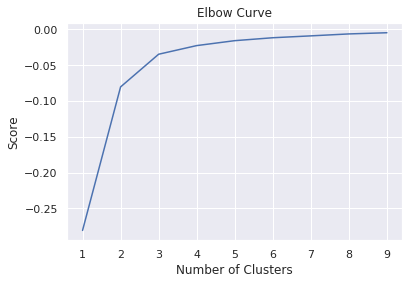

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
%matplotlib inline

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df[['Latitude']]
X_axis = df[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

**Using k=3 k-means clustering, assign cluster value to each neighborhood and allot to a column within the dataframe.**

In [168]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(Y_axis)
ClusterLabel=kmeans.predict(Y_axis)
df['Cluster Label']=ClusterLabel
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Label
0,M3A,North York,Parkwoods,43.753259,-79.329656,2
1,M4A,North York,Victoria Village,43.725882,-79.315572,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1


**Using a for loop and if-then statements, plot neighborhoods in folium where color is derived from Cluster Label value.**

In [179]:
map_toronto=folium.Map(location=[43.6,-79.3],zoom_start=10)

for lat,lng,borough,neighborhood,value in zip(df['Latitude'],df['Longitude'],df['Borough'],df['Neighborhood'],df['Cluster Label']):
    if value==0:
        colorVar='red'
    elif value==1:
        colorVar='blue'
    elif value==2:
        colorVar='yellow'
    else:
        colorVar='green'
    label='{},{}'.format(neighborhood,borough)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color=colorVar,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
        
map_toronto

**FourSquare API request to explore venues related to each neighborhood.**

In [188]:
CLIENT_ID = 'GXRXGYGOAW5FTISJGVPBEXRN21UZVRZLNS3AF0XJWXTRVZVE' # your Foursquare ID
CLIENT_SECRET = 'NFWK30OHOK2OIE3NGDWASH3LULKL0IVAOO0JDPQPVDKFGN5Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=10

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']  
    return(nearby_venues)

In [189]:
venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
print(venues.shape)
venues.head()

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Brookbanks Pool,43.751389,-79.332184,Pool
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [191]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 182 uniques categories.


In [193]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,...,Theme Restaurant,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
num_top_venues = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1  Latin American Restaurant  0.25
2             Clothing Store  0.25
3             Breakfast Spot  0.25
4                Yoga Studio  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.33
1     Coffee Shop  0.17
2  Sandwich Place  0.17
3             Pub  0.17
4             Gym  0.17


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Coffee Shop   0.2
1  Middle Eastern Restaurant   0.1
2              Deli / Bodega   0.1
3             Ice Cream Shop   0.1
4                      Diner   0.1


----Bayview Village----
                 venue  freq
0                 Café  0.25
1   Chinese Restaurant  0.25
2                 Bank  0.25
3  Japanese Restaurant  0.25
4        Movie Theater  0.00


----Bedford Park, Lawrence Manor East----
                     venue  freq
0                Juice Bar   0.1
1               R

                  venue  freq
0                   Gym   0.1
1        Ice Cream Shop   0.1
2             Pet Store   0.1
3                  Park   0.1
4  Fast Food Restaurant   0.1


----Kennedy Park, Ionview, East Birchmount Park----
              venue  freq
0        Hobby Shop   0.2
1       Coffee Shop   0.2
2       Bus Station   0.2
3  Department Store   0.2
4    Discount Store   0.2


----Kensington Market, Chinatown, Grange Park----
                   venue  freq
0                   Café   0.3
1  Vietnamese Restaurant   0.2
2     Mexican Restaurant   0.1
3        Organic Grocery   0.1
4    Arts & Crafts Store   0.1


----Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens----
                        venue  freq
0                        Park  0.33
1           Mobile Phone Shop  0.33
2              Sandwich Place  0.33
3                 Yoga Studio  0.00
4  Modern European Restaurant  0.00


----Lawrence Manor, Lawrence Heights----
                    venue  freq

              venue  freq
0  Greek Restaurant   0.3
1    Ice Cream Shop   0.2
2       Yoga Studio   0.1
3    Cosmetics Shop   0.1
4           Brewery   0.1


----The Kingsway, Montgomery Road, Old Mill North----
            venue  freq
0            Park   0.5
1           River   0.5
2     Yoga Studio   0.0
3           Motel   0.0
4  Medical Center   0.0


----Thorncliffe Park----
               venue  freq
0  Indian Restaurant   0.2
1        Yoga Studio   0.1
2       Burger Joint   0.1
3    Warehouse Store   0.1
4     Sandwich Place   0.1


----Toronto Dominion Centre, Design Exchange----
                  venue  freq
0                  Café   0.2
1                   Gym   0.1
2  Gym / Fitness Center   0.1
3                   Pub   0.1
4           Coffee Shop   0.1


----University of Toronto, Harbord----
               venue  freq
0        Yoga Studio   0.1
1         Restaurant   0.1
2          Bookstore   0.1
3  French Restaurant   0.1
4           Beer Bar   0.1


----Victoria Villag